# Snake Voice‑Command Classification

This notebook trains two different models (CNN and CRNN) on a spoken‑command dataset, selects the best performer on the validation split, and evaluates it on an unseen test split.

This work is inspired by the TensorFlow keyword‑spotting tutorial: [Keyword Spotting](https://www.tensorflow.org/tutorials/audio/simple_audio)

## Imports & Dependencies

In [1]:
from functools import partial

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras import layers, models
from IPython import display

from models.cnn_model import build_cnn_model
from models.crnn_model import build_crnn_model
from models.hyper_model import build_hypermodel

In [ ]:
SEED = 42   # ensures consistants for reproducibility and training
np.random.seed(SEED)
tf.random.set_seed(SEED)

DATA_DIR = "../data/snake_commands"
BATCH_SIZE = 64
EPOCHS = 10

## Helper functions
This section defines functions to prepare raw audio for model input and to visulaize results:
1. **Data Preprocessing**
    - `squeeze(audio, labels)`: removes extra chennel dimension.
    - `get_spectrogram(waveform)`: computes STFT and returns a magnitude spectrogram with shape `(time, freq, 1)`.
    - `make_spec_ds(ds)`: maps `get_spectrogram`over a dataset pipeline with parallel calls.
2. **Visualization utilities**
    - `plot_spectrogram(...)`: displays a log-scaled spectrogram.
    - `plot_history(...)`: plots training/validation loss and accuracy.
    - `plot_confusion_matrix(...)`: computes predictions, builds a confusion matrix, and visualizes it with Seaborn.

In [3]:
def squeeze(audio, labels):
    """Remove the last dimension of the audio tensor."""
    audio = tf.squeeze(audio, axis=-1)
    return audio, labels

In [4]:
def get_spectrogram(waveform):
    """ Compute STFT and return magnitude spectrogram with axis."""
    spectogram = tf.signal.stft(waveform, frame_length=255, frame_step=128)
    spectogram = tf.abs(spectogram)[..., tf.newaxis]
    return spectogram

In [5]:
def plot_spectrogram(spectogram, ax):
    """Plot log-scaled spectrogram."""
    if spectogram.ndim == 3:
        spectogram = np.squeeze(spectogram, axis=-1)
    log_spec = np.log(spectogram.T + np.finfo(float).eps)
    h, w = log_spec.shape
    X = np.linspace(0, np.size(spectogram), num=w, dtype=int)
    Y = range(h)
    ax.pcolormesh(X, Y, log_spec)

In [6]:
def make_spec_ds(ds):
    return ds.map(
        map_func=lambda audio, label: (get_spectrogram(audio), label),
        num_parallel_calls=tf.data.AUTOTUNE
    )

In [7]:
def plot_history(history, prefix="Model"):
    """Plot training and validation loss & accuracy"""
    hist = history
    plt.figure(figsize=(16,6))
    plt.subplot(1,2,1)
    plt.plot(hist['loss'], label='train_loss')
    plt.plot(hist['val_loss'], label='val_loss')
    plt.title(f'{prefix} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(np.array(hist['accuracy'])*100, label='train_accuracy')
    plt.plot(np.array(hist['val_accuracy'])*100, label='val_accuracy')
    plt.title(f'{prefix} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy [%]')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [8]:
def plot_confusion_matrix(model, ds, labels):
    """Compute and plot confusion matrix on dataset"""
    preds = model.predict(ds)
    y_pred = tf.argmax(preds, axis=1)
    y_true = tf.concat([l for _, l in ds.map(lambda s, l: (s, l))], axis=0)

    cm = tf.math.confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, xticklabels=labels, yticklabels=labels,annot=True, fmt='g')
    plt.xlabel('Prediction') 
    plt.ylabel('Label')
    plt.show()

## Data Loading & Initial Visualization

In [ ]:
# List all subfolders in the data directory and filter out unwanted files

commands = np.array(tf.io.gfile.listdir(str(DATA_DIR)))
commands = commands[(commands != 'README.md') & (commands != '.DS_Store')]
print('Raw folders (commands):', commands)

Raw folders (commands): ['right' 'left' 'up' 'down']


Load and split the audio dataset into an 80/20 split, then shards validation set further to separate test and validation subsets.

In [10]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=DATA_DIR,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    seed=SEED,
    output_sequence_length=16000,
    subset='both'
)

label_names = np.array(train_ds.class_names)
print("\nLabel names:", label_names)

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

Found 9454 files belonging to 4 classes.
Using 7564 files for training.
Using 1890 files for validation.

Label names: ['down' 'left' 'right' 'up']


## Example waveform and spectrogram

In [11]:
# Inspect shapes
for example_audio, example_labels in train_ds.take(1):
    print("Audio shape:", example_audio.shape)
    print("Labels shape:", example_labels.shape)

Audio shape: (64, 16000)
Labels shape: (64,)


2025-04-20 13:58:47.380297: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


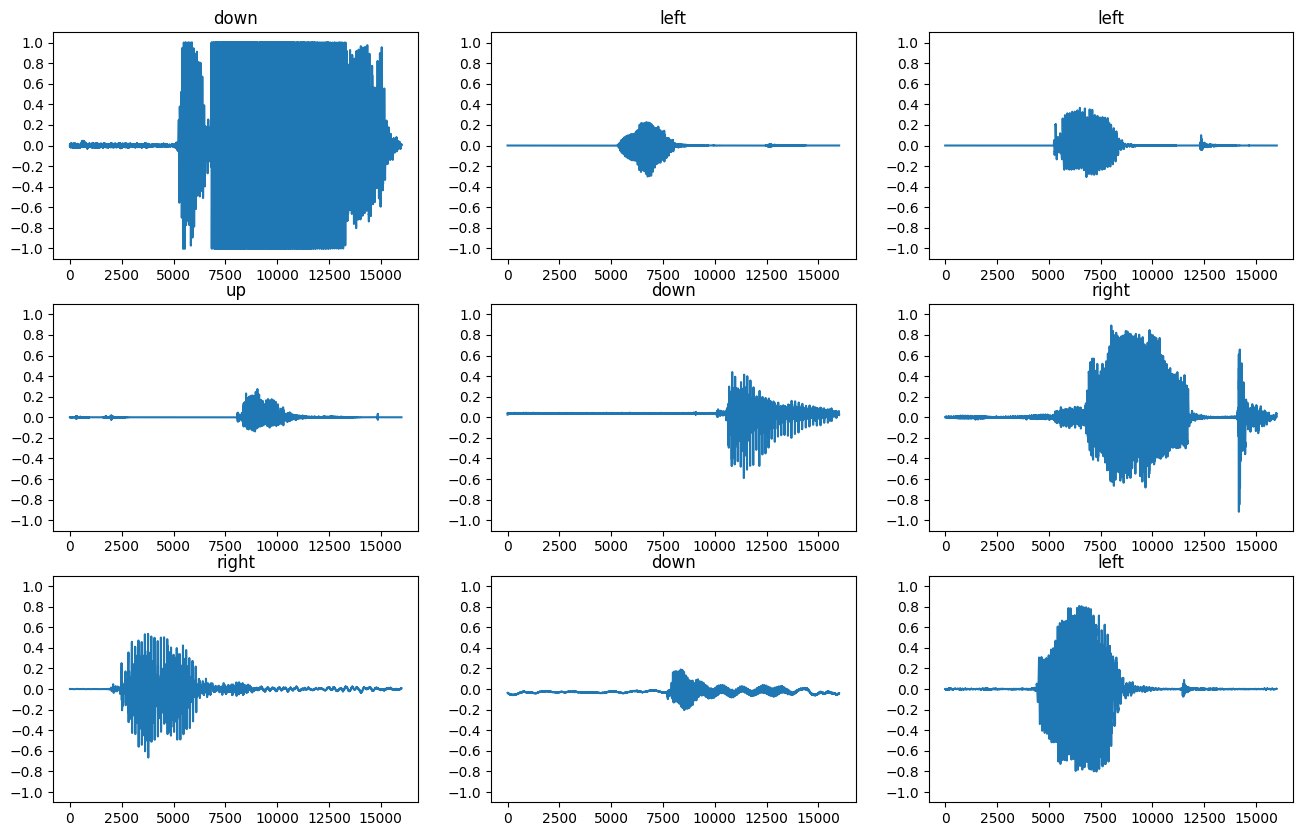

In [12]:
# Plot a few raw waveforms
plt.figure(figsize=(16, 10))
rows, cols = 3, 3
n = rows * cols
for i in range(n):
    plt.subplot(rows, cols, i+1)
    plt.plot(example_audio[i])
    plt.title(label_names[example_labels[i]])
    plt.yticks(np.arange(-1.2, 1.2, 0.2))
    plt.ylim([-1.1, 1.1])
plt.show()

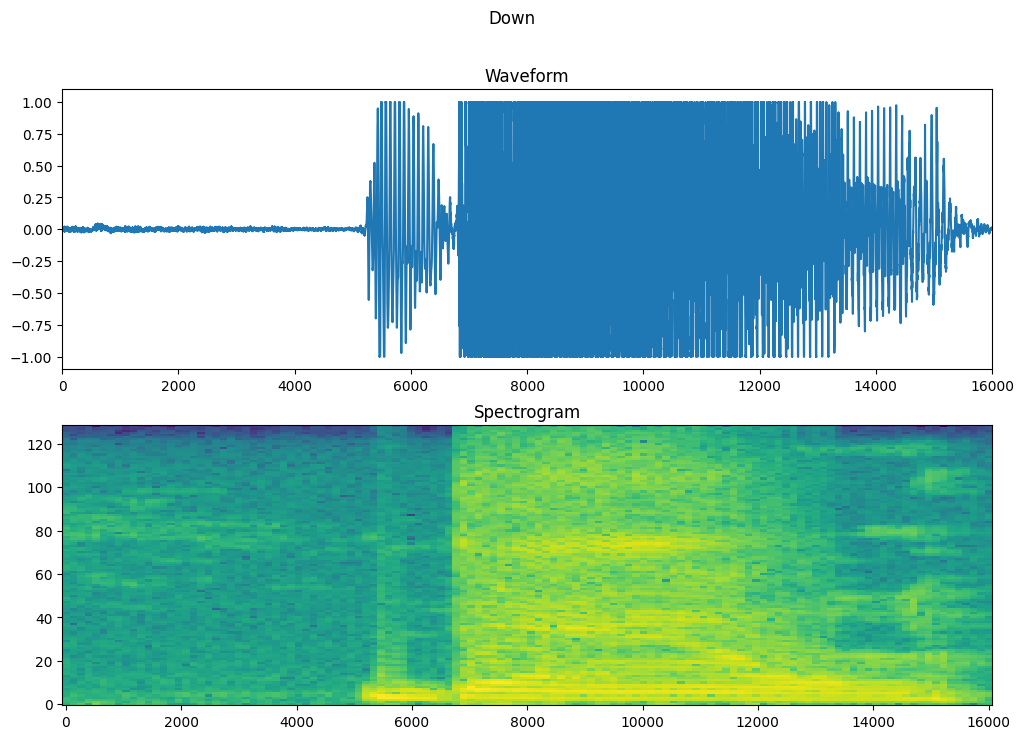

In [13]:
# Show waveform + spectrogram + play audio for one example
waveform = example_audio[0]
spectrogram = get_spectrogram(waveform)

fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set(title='Waveform', xlim=[0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label_names[example_labels[0]].title())
plt.show()

display.display(display.Audio(waveform, rate=16000))

## Spectrogram Dataset Preparation

Convert each dataset split into spectrograms, then apply caching, shuffling, and prefetching to optimize the input pipeline.

In [14]:
train_spec_ds = make_spec_ds(train_ds).cache().shuffle(10000, seed=SEED).prefetch(tf.data.AUTOTUNE)
val_spec_ds   = make_spec_ds(val_ds).cache().prefetch(tf.data.AUTOTUNE)
test_spec_ds  = make_spec_ds(test_ds).cache().prefetch(tf.data.AUTOTUNE)

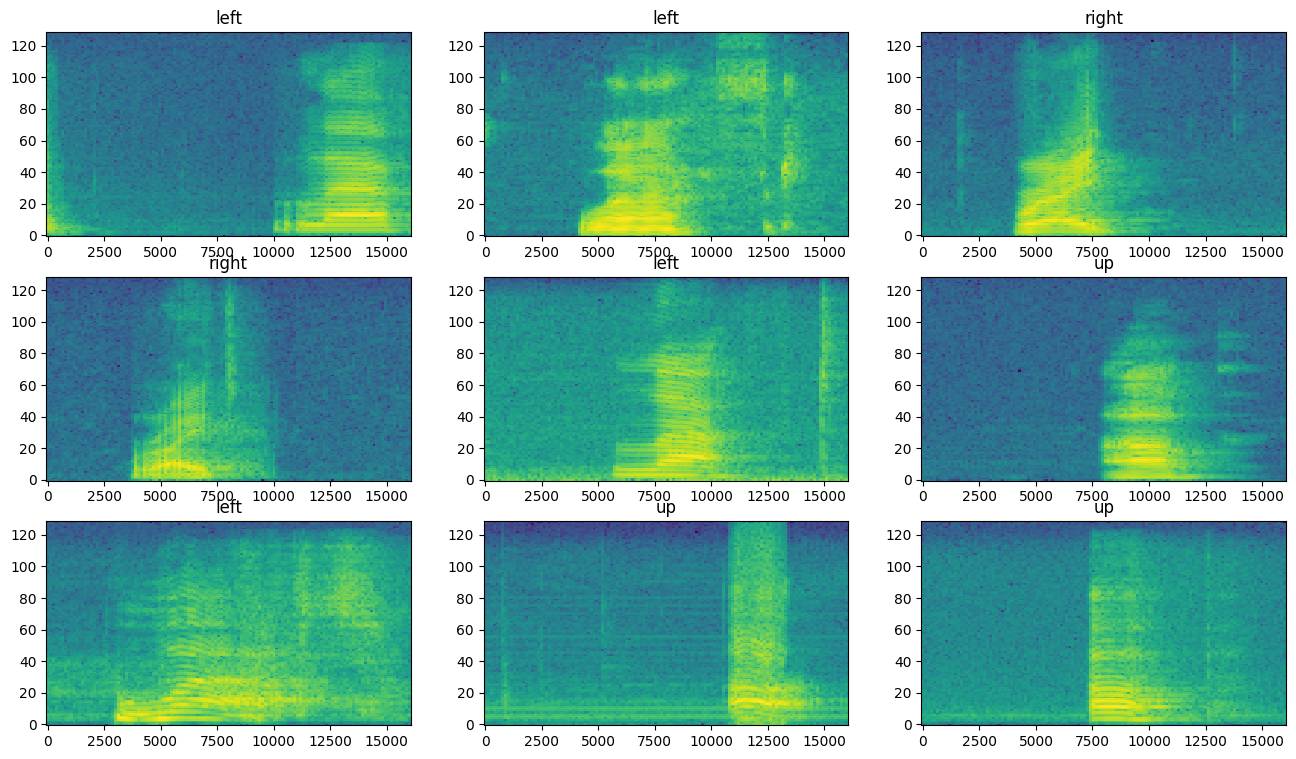

In [15]:
# Visual check of a few spectrgrams
for spec_batch, label_batch in train_spec_ds.take(1):
    example_specs = spec_batch.numpy()
    example_labs  = label_batch.numpy()
    break

rows, cols = 3, 3
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))
for i in range(rows*cols):
    r, c = divmod(i, cols)
    plot_spectrogram(example_specs[i], axes[r][c])
    axes[r][c].set_title(label_names[example_labs[i]])
plt.show()

## Build and compile baseline models
First, we inspect one batch of spectrograms to determine:
- **`input_shape`**: the dimensions of a single spectrogram (time x frequency x channels)
- **`num_labels`**: the total number of commend classes

We then create a `Normalization()` layer and call `.adapt()` on our training spectrograms so that each input feature is standardized (zero mean, unit variance) before being fed into the network.

Next, we instantiate two baseline models: **CNN** and **CRNN**

Finally, we compile both models with:
- **Optimizer**: Adam (learning rate = 0.001)
- **Loss**: Sparse Categorical Crossentropy (for integer class labels)
- **Metrics**: Accuracy (to track classification performance)

In [16]:
# Determine input shape and setup normalization
for specs, _ in train_spec_ds.take(1):
    input_shape = specs.shape[1:]
num_labels = len(label_names)
print("Input shape:", input_shape, "\nNumber of classes:", num_labels)

norm_layer = layers.Normalization()
norm_layer.adapt(train_spec_ds.map(lambda spec, lab: spec))

2025-04-20 13:58:49.685290: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Input shape: (124, 129, 1) 
Number of classes: 4


In [17]:
# Build models
models_dict = {
    'CNN':  build_cnn_model(input_shape, num_labels, norm_layer),
    'CRNN': build_crnn_model(input_shape, num_labels, norm_layer)
}

for name, m in models_dict.items():
    print(f"\n{'='*10} Summary for {name} {'='*10}\n")
    m.summary()

    m.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=['accuracy']
    )


========== Summary for CNN ==========



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing (Resizing)             │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization (Normalization)   │ (None, 32, 32, 1)      │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,625,095 (6.20 MB)

 Trainable params: 1,625,092 (6.20 MB)

 Non-trainable params: 3 (16.00 B)


========== Summary for CRNN ==========



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing_1 (Resizing)           │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization (Normalization)   │ (None, 32, 32, 1)      │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 30, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 36, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 36, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,703 (366.03 KB)

 Trainable params: 93,700 (366.02 KB)

 Non-trainable params: 3 (16.00 B)

## Baseline training
We train each model for up to 10 epochs, using early stopping (patience=5) on the validation loss to prevent overfitting.

In [18]:
# Train with early stopping
histories = {}
EPOCHS = 10
for name, m in models_dict.items():
    print(f"\n=== Training {name} ===")
    histories[name] = m.fit(
        train_spec_ds,
        validation_data=val_spec_ds,
        epochs=EPOCHS,
        callbacks=[tf.keras.callbacks.EarlyStopping(verbose=1, patience=5)]
    )


=== Training CNN ===
Epoch 1/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - accuracy: 0.4677 - loss: 1.2079 - val_accuracy: 0.8269 - val_loss: 0.5510
Epoch 2/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.8397 - loss: 0.4947 - val_accuracy: 0.9151 - val_loss: 0.3022
Epoch 3/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.9150 - loss: 0.2835 - val_accuracy: 0.9215 - val_loss: 0.2343
Epoch 4/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.9307 - loss: 0.2011 - val_accuracy: 0.9172 - val_loss: 0.2467
Epoch 5/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.9482 - loss: 0.1511 - val_accuracy: 0.9323 - val_loss: 0.2074
Epoch 6/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.9598 - loss: 0.1218 - val_accuracy: 0.9419 - val_loss: 0.1736
Epoch 7/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.9548 - loss: 0.1229 - val_accuracy: 0.9484 - val_loss: 0.1786
Epoch 8/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.9667 - l

After training, we pick the model with the highest validation accuracy

In [19]:
best_name = max(histories, key=lambda n: max(histories[n].history['val_accuracy']))
best_model = models_dict[best_name]

baseline_val_acc = max(histories[best_name].history['val_accuracy'])
baseline_val_loss = min(histories[best_name].history['val_loss'])
print(f"Best baseline model: {best_name} with val_acc={baseline_val_acc:.3f}, val_loss={baseline_val_loss:.3f}")

Best baseline model: CNN with val_acc=0.948, val_loss=0.170


## Hyperparameter tuning
Configure a KerasTuner `RandomSearch`:
- Objective: maximum validation accuracy.
- Up to 20 tials
- Uses our `build_hypermodel`wrapper to vary layer sizes, learning rate, etc.

In [20]:
hypermodel = partial(
    build_hypermodel,
    best_name=best_name,
    input_shape=input_shape,
    num_labels=num_labels,
    norm_layer=norm_layer
)

print(f"Starter hyperparameter tuning (random search) for modellen: {best_name}")
tuner = kt.RandomSearch(
    hypermodel,
    seed = SEED,
    objective='val_accuracy',
    max_trials=20,
    executions_per_trial=1,
    directory='kt_tuner',
    project_name=f'random_search_{best_name.lower()}'
)

Starter hyperparameter tuning (random search) for modellen: CNN


In [21]:
# Kjør hypertuning
tuner.search(
    train_spec_ds,
    validation_data=val_spec_ds,
    epochs=EPOCHS,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, verbose=1)]
)

Trial 20 Complete [00h 05m 15s]
val_accuracy: 0.92580646276474

Best val_accuracy So Far: 0.9559139609336853
Total elapsed time: 00h 28m 51s


## Train Tuned Model
Retrive the best hyperparameter set, display each chosen value, and rebuild the model accordingly.

In [22]:
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
print("\nBest hyperparameters:")
for name, value in best_hp.values.items():
    print(f"{name}: {value}")
tuned_model = tuner.hypermodel.build(best_hp)


Best hyperparameters:
conv1_filters: 64
conv1_kernel: 3
conv2_filters: 64
conv2_kernel: 5
dropout_1: 0.5
dense_units: 64
dropout_2: 0.30000000000000004
learning_rate: 0.0010277342442932575


In [23]:
# Tren final modell
history_tuned = tuned_model.fit(
    train_spec_ds,
    validation_data=val_spec_ds,
    epochs=EPOCHS,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, verbose=1)]
)

Epoch 1/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - accuracy: 0.4790 - loss: 1.1675 - val_accuracy: 0.8570 - val_loss: 0.4477
Epoch 2/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 15s 123ms/step - accuracy: 0.8554 - loss: 0.4542 - val_accuracy: 0.9172 - val_loss: 0.2716
Epoch 3/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 14s 120ms/step - accuracy: 0.9047 - loss: 0.3046 - val_accuracy: 0.9054 - val_loss: 0.2507
Epoch 4/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 14s 120ms/step - accuracy: 0.9198 - loss: 0.2374 - val_accuracy: 0.9129 - val_loss: 0.2539
Epoch 5/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 14s 118ms/step - accuracy: 0.9412 - loss: 0.1743 - val_accuracy: 0.9226 - val_loss: 0.2030
Epoch 6/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 15s 126ms/step - accuracy: 0.9440 - loss: 0.1653 - val_accuracy: 0.9387 - val_loss: 0.1696
Epoch 7/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 14s 117ms/step - accuracy: 0.9569 - loss: 0.1300 - val_accuracy: 0.9290 - val_loss: 0.1920
Epoch 8/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 14s 119ms/step - accuracy: 0.9548 - loss: 0

In [24]:
tuned_val_acc = max(history_tuned.history['val_accuracy'])
tuned_val_loss = min(history_tuned.history['val_loss'])
print(f"Tuned model: val_acc={tuned_val_acc:.3f}, val_loss={tuned_val_loss:.3f}")

Tuned model: val_acc=0.948, val_loss=0.159


## Final model selection & evaluation
Check if the tuned model outpreforms the baseline, then select the model that has the higher validation accuracy. Then we evaluate that model on the test set.

In [25]:
if tuned_val_acc > baseline_val_acc:
    final_model = tuned_model
    final_history = history_tuned.history
    val_acc = tuned_val_acc
    val_loss = tuned_val_loss
    source = 'Tuned'
else:
    final_model = best_model
    final_history = histories[best_name].history
    val_acc = baseline_val_acc
    val_loss = baseline_val_loss
    source = 'Baseline'
print(f"Final model source: {source} with val_acc={val_acc:.3f}, val_loss={val_loss:.3f}")

Final model source: Baseline with val_acc=0.948, val_loss=0.170


In [26]:
print("=== Evaluating tuned model on test set ===")
results = final_model.evaluate(test_spec_ds, return_dict=True)
print(f"{source} modell test results:", results)

final_model.save(f"final_voice_model.keras")
print(f"\nSaved the {best_name} model.")

=== Evaluating tuned model on test set ===
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9485 - loss: 0.1774
Baseline modell test results: {'accuracy': 0.949999988079071, 'loss': 0.16188094019889832}

Saved the CNN model.


## Visualization of final results

Visualize training vs. validation loss and accuracy for the chosen model to ensure stable convergence.

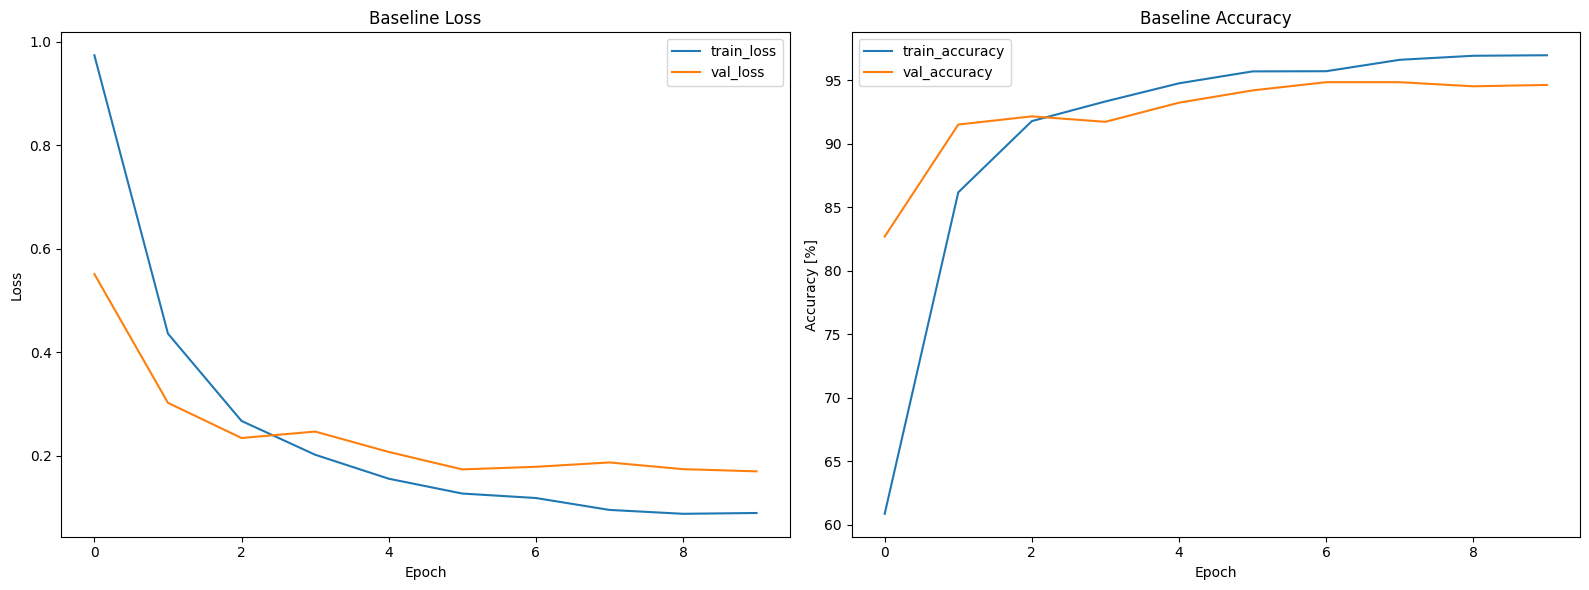

In [27]:
plot_history(final_history, prefix=source)

Generate and display a confusion matrix for the final model's predictions on the test set to identify which commands are most often misclassified.

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


2025-04-20 14:31:43.983291: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


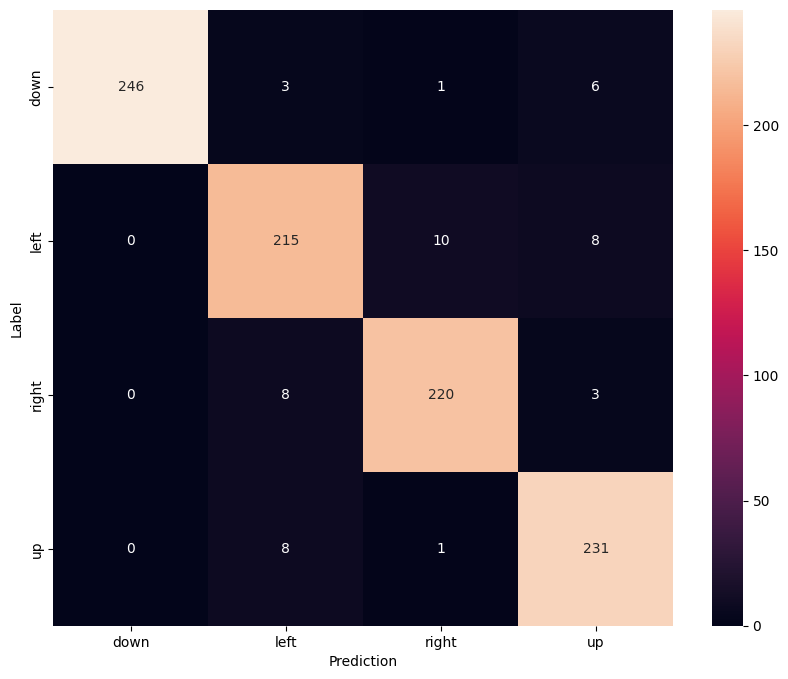

In [28]:
plot_confusion_matrix(final_model, test_spec_ds, label_names)